# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.
Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

In [5]:
!pip install datasets sacremoses

## 1단계: Last Word Prediction용 Dataset 준비

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizerFast
import numpy as np

# 데이터셋 로드
train_ds = load_dataset("stanfordnlp/imdb", split="train[:5%]")
test_ds = load_dataset("stanfordnlp/imdb", split="test[:5%]")

# Tokenizer
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

# Collate function for last word prediction
def collate_fn(batch):
    max_len = 400
    texts, labels = [], []

    for row in batch:
        tokens = tokenizer(row['text'], truncation=True, max_length=max_len).input_ids
        if len(tokens) < 4: continue  # 너무 짧은 문장 패스
        labels.append(tokens[-3])  # 예측할 마지막 토큰
        texts.append(torch.LongTensor(tokens[:-3]))  # 입력은 마지막 3개 제외

    texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.LongTensor(labels)
    return texts, labels

# DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn
)


## 2단계: 모델
* 변경사항
- 출력층 Linear(d_model → vocab_size)로 수정
- Loss 함수 CrossEntropyLoss()로 변경 (label은 token id이므로)
- 마지막 hidden state는 여전히 x[:, 0] 또는 x[:, -1] 중 선택 가능



In [2]:
from torch import nn
from math import sqrt
import numpy as np


# Self-Attention Layer
class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

# Transformer Block
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

# Positional Encoding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)




# TextClassifier for token classification
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.parameter.Parameter(positional_encoding(400, d_model), requires_grad=False)
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
        self.classification = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)[:, None, :]
        x = self.embedding(x) * sqrt(self.embedding.embedding_dim)
        x = x + self.pos_encoding[:, :x.size(1)]
        for layer in self.layers:
            x = layer(x, mask)
        return self.classification(x[:, -1])  # 마지막 토큰의 representation 사용



max_len = 400
print(positional_encoding(max_len, 256).shape)


torch.Size([1, 400, 256])


In [3]:
def accuracy(model, dataloader):
  cnt, acc = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')
    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    acc += (preds == labels).sum().item()
    cnt += labels.size(0)
  return acc / cnt


## 3단계: 학습 루프

In [6]:
from torch.optim import Adam

device = 'cuda'
model = TextClassifier(len(tokenizer), d_model=32, n_layers=2, dff=64).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

train_losses = []
train_accuracies = []
test_accuracies = []


n_epochs = 50

for epoch in range(n_epochs):
    total_loss = 0
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    train_losses.append(total_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch}] Loss: {total_loss:.4f}, Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}")

[Epoch 0] Loss: 205.3157, Train Acc: 0.000, Test Acc: 0.000
[Epoch 1] Loss: 175.3220, Train Acc: 0.041, Test Acc: 0.024
[Epoch 2] Loss: 137.5618, Train Acc: 0.041, Test Acc: 0.024
[Epoch 3] Loss: 124.3951, Train Acc: 0.040, Test Acc: 0.049
[Epoch 4] Loss: 120.3062, Train Acc: 0.034, Test Acc: 0.034
[Epoch 5] Loss: 118.4701, Train Acc: 0.040, Test Acc: 0.049
[Epoch 6] Loss: 117.7581, Train Acc: 0.041, Test Acc: 0.024
[Epoch 7] Loss: 117.3902, Train Acc: 0.034, Test Acc: 0.034
[Epoch 8] Loss: 116.3258, Train Acc: 0.040, Test Acc: 0.049
[Epoch 9] Loss: 116.2270, Train Acc: 0.040, Test Acc: 0.049
[Epoch 10] Loss: 115.9310, Train Acc: 0.040, Test Acc: 0.049
[Epoch 11] Loss: 115.5678, Train Acc: 0.041, Test Acc: 0.024
[Epoch 12] Loss: 115.5154, Train Acc: 0.041, Test Acc: 0.024
[Epoch 13] Loss: 115.0901, Train Acc: 0.040, Test Acc: 0.049
[Epoch 14] Loss: 114.8497, Train Acc: 0.041, Test Acc: 0.024
[Epoch 15] Loss: 114.7530, Train Acc: 0.041, Test Acc: 0.026
[Epoch 16] Loss: 114.3499, Train A

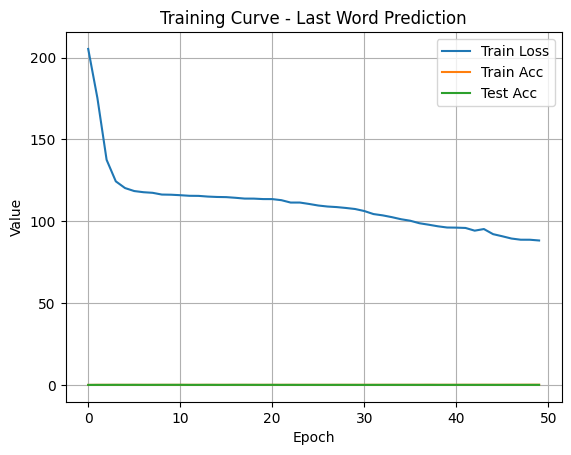

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Curve - Last Word Prediction')
plt.legend()
plt.grid(True)
plt.show()
